In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
# from keras import models as md
from keras import layers as ly
import numpy as np
import cv2
from skimage import io
from google.colab import drive
import os
import keras.backend as kb
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# U-net settings :O

sz = (
  (768, 544),
  (448, 320),
  (320, 224),
  (224, 160)
)
IMG_H, IMG_W = sz[2]     #  must be integers divisible by pow(2,number_of_layers)


## data preparation

In [ ]:
def padding(img, dh, dw):
  ''' adds black bars at the borders of the image to fit its size '''

  h,w = np.shape(img)[:2]
  start_h = (dh-h)//2
  start_w = (dw-w)//2
  imres = np.full((dh,dw,3), (0,0,0), dtype=np.uint8)
  imres[start_h : start_h+h, start_w : start_w+w] = img
  return imres

def im_resize(img, dh=IMG_H, dw=IMG_W):
  ''' receives an image and returns a resized version of shape (dh, dw) '''

  h,w = np.shape(img)[:2]
  return im_resize1(img, h, w, dh, dw)

def im_resize0(img, h, w, dh, dw):
  ''' image resizing using bilinear interpolation and padding. '''
  
  if h/w > dh/dw:    # make the image shorter
      img = cv2.resize(img, ((w*dh)//h, dh))
  else:      # make the image taller
      img = cv2.resize(img, (dw, (h*dw)//w))
  return padding(img, dh, dw)

def im_resize1(img, h, w, dh, dw):

  return cv2.resize(img, (dw, dh))


In [ ]:
def prepare_data(train_p, test_p, verbose=False, saveToFile=False):
  ''' read images and divide them to train, test and validation portions '''

  file_path = r"/content/drive/MyDrive/finished/version2"

  imgs = []
  lbls = []
  counter = 0
  for fn in os.listdir(f"{file_path}/data"):
    counter+=1
    if verbose:     # print the numbers of the files which are being loaded
      print(f'{counter}, ', end=(not counter%10)*'\n')
    
    img_i = cv2.imread(f"{file_path}/data/{fn}")
    if len(np.shape(img_i))==3:
      # for reasons unbeknownst to yours truly, cv2 reads images in the color
      # order BGR and not RGB
      img_i = np.flip(img_i, 2)

    img_i = im_resize(img_i)
    img_i = cv2.normalize(img_i.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    imgs.append(img_i)
    imgs.append(cv2.flip(img_i,1))

    lbl_i = cv2.imread(f"{file_path}/labels/{fn}")
    lbl_i = im_resize(lbl_i)
    r,g,b = lbl_i[:,:,0], lbl_i[:,:,1], lbl_i[:,:,2]
    rs = (r>=240) & (g<=15) & (b<=15)
    gs = (g>=240) & (b<=15) & (r<=15)
    bs = (b>=240) & (r<=15) & (g<=15)
    sp_locs = rs | gs | bs
    lbls.append(sp_locs)
    lbls.append(np.flip(sp_locs, 1))

  imgs = np.asarray(imgs)
  lbls = np.asarray(lbls)
  sh = np.shape(imgs)[0]
  xs = np.arange(0,sh)
  np.random.shuffle(xs)   # xs is now a permutation which is of the same length as the image count

  tr_p = int(train_p*len(imgs))     # the number of images to be used for training
  te_p = int((train_p+test_p)*len(imgs))     # the number of images to be used for testing
  tr_i = xs[ : tr_p]
  te_i = xs[tr_p : te_p]
  va_i = xs[te_p : ]

  train = (imgs[tr_i], lbls[tr_i])    # train data
  test  = (imgs[te_i], lbls[te_i])    # test data
  valid = (imgs[va_i], lbls[va_i])    # validation data

  cnt=0
  #for ds in (train,test,valid):
   # for img,lbl in zip(ds[0], ds[1]):
    #  cnt += 1
     # np.append(ds[0], [np.flip(img,1)])
      # np.append(ds[1], [np.flip(lbl,1)])

      #if saveToFile:
       # io.imsave(f'{file_path}/load/{cnt}1.jpg', np.asarray(255*img,dtype=np.uint8))
        #io.imsave(f'{file_path}/load/{cnt}2.jpg', np.asarray(255*lbl,dtype=np.uint8))
        # io.imsave(f'{file_path}/load/{fn[:-4]}3.jpg', np.full((IMG_H,IMG_W),255, dtype=np.uint8)*sp_locs)

  print(cnt)
  return train, test, valid


In [ ]:
train, test, valid = prepare_data(0.7, 0.3, verbose=True, saveToFile=True)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
41, 42, 43, 44, 45, 46, 47, 0


## unet definition

In [ ]:
class Encoder:  # the contracting path
	def __init__(self, input_h, input_w, channels, _lyr_cnt):
		self.h = input_h
		self.w = input_w
		self.c = channels
		self.lyr_cnt = _lyr_cnt

	def lyr(self, i, ops):
		l = eval("self._lyr%d(ops)" % i)   # will raise a suitable error if no such function exists
		return l


In [ ]:
class VGG_Encoder(Encoder):
	def __init__(self, input_h, input_w, channels, _drop_out=False, _batch_norm=False):
		super().__init__(input_h, input_w, channels, 5)
		assert input_h % (2 ** self.lyr_cnt) == 0
		assert input_w % (2 ** self.lyr_cnt) == 0
		self.drop_out = _drop_out
		self.batch_norm = _batch_norm

	def conv(self, ops, filters):
		ops = ly.Conv2D(filters, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(ops)
		if self.batch_norm:
			ops = ly.BatchNormalization()(ops)
		if self.drop_out:
			ops = ly.Dropout(0.2)(ops)
		return ops

	def _lyr1(self, ops):
		for _ in range(2):
			ops = self.conv(ops, 64)
		return ops

	def _lyr2(self, ops):
		ops = ly.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(ops)
		for _ in range(2):
			ops = self.conv(ops, 128)
		return ops

	def _lyr3(self, ops):
		ops = ly.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(ops)
		for _ in range(3):
			ops = self.conv(ops, 256)
		return ops

	def _lyr4(self, ops):
		ops = ly.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(ops)
		for _ in range(2):
			ops = self.conv(ops, 512)
		return ops

	def _lyr5(self, ops):
		ops = ly.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(ops)
		for _ in range(2):
			ops = self.conv(ops, 1024)
		return ops

	def load_weights(weights_url=None):
		vgg_weights = keras.utils.get_file(weights_url.split("/")[-1], weights_url)
		Model(img_input, x).load_weights(vgg_weights, by_name=True, skip_mismatch=True)


In [ ]:
import numpy as np
from tensorflow import keras as ks
import cv2
# from encoder import Encoder
# from data import im_resize
# from unet_settings import *


class Unet:
	def __init__(self, height, width, channels, encoder=None):
		''' initialize the unet '''

		if encoder is None:
			encoder = Encoder(height, width, channels, 5)
		self.encoder = encoder
		(self.h, self.w, self.c) = (height, width, channels)
		self.model = ks.Model()

	def encode(self):
		''' the contracting path '''

		f = [ks.Input((self.h, self.w, self.c))]
		for i in range(1, self.encoder.lyr_cnt + 1):
			ops = self.encoder.lyr(i, f[-1])
			if i>=4:
				ops = ly.Dropout(0.5)(ops)
			f.append(ops)
		return f

	def set_options(self, loss=None):
		''' compile the model '''

		optimizer = ks.optimizers.Adam(learning_rate=0.0001)
		# optimizer = ks.optimizers.Adam(learning_rate=0.0005) # THIS IS THE GOOD ONE
		if loss is None:
			loss = ks.losses.binary_crossentropy
		self.model.compile(optimizer, loss, metrics=["acc"])
	
	
	def train(self, train_data, train_labels, file_name="best_weights.h5",
						 verbose=True, bsize=32):
		''' in this method the model is trained!
		train data and labels are passed as arguments.
		file_name is where the trained weights will be saved
		'''
	
    # callbacks = [
		# 	ks.callbacks.ReduceLROnPlateau(factor=0.3, patience=5, min_lr=1e-6, verbose=verbose),
		# ]
		model_checkpoint = ks.callbacks.ModelCheckpoint('best_weights.h5', monitor='loss', verbose=verbose, save_best_only=True)
		self.model.fit(train_data, train_labels, epochs=15, steps_per_epoch=150, \
                 batch_size=bsize, callbacks=[model_checkpoint])
	
	
	def train1(self, train_data, train_labels, valid_data, valid_labels, file_name="best_weights.h5",
						 verbose=True):
		callbacks = [
			ks.callbacks.ReduceLROnPlateau(factor=0.3, patience=5, min_lr=1e-5, verbose=verbose),
			# ks.callbacks.ModelCheckpoint(file_name, verbose=verbose, save_best_only=True, \
			# 							 save_weights_only=True)
		]
		results = self.model.fit(train_data, train_labels, epochs=25, callbacks=callbacks, \
														 validation_data=(valid_data, valid_labels), \
														 steps_per_epoch=3)
	
	
	def predict_segmentation(self, img):
		''' predict the locations of  '''
	
		h, w = np.shape(img)[:2]
		pred = self.model.predict(np.array([img]))
		return pred
	
	
	def load_weights(self, weights_dir):
		self.model.load_weights(weights_dir)


In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers as ly


class VGG_Unet(Unet):
	def __init__(self, height, width, channels, encoder=None):
		if encoder is None:
			encoder = VGG_Encoder(height, width, channels)
		super().__init__(height, width, channels, encoder)

	def process(self):  # encode and decode
		enc = self.encode()

		dec = [None] * 4
		dropout = 0.2     # the frequency at which inputs are ignored
		last = enc[5]

		dec[0] = ly.UpSampling2D(size=(2, 2))(last)
		dec[0] = self.encoder.conv(dec[0], 512)
		dec[0] = ly.Concatenate(axis=-1)([dec[0], enc[4]])
		for _ in range(2):
			dec[0] = self.encoder.conv(dec[0], 512)

		dec[1] = ly.UpSampling2D(size=(2, 2))(dec[0])
		dec[1] = self.encoder.conv(dec[1], 256)
		dec[1] = ly.Concatenate(axis=-1)([dec[1], enc[3]])
		for _ in range(2):
			dec[1] = self.encoder.conv(dec[1], 256)

		dec[2] = ly.UpSampling2D(size=(2, 2))(dec[1])
		dec[2] = self.encoder.conv(dec[2], 128)
		dec[2] = ly.Concatenate(axis=-1)([dec[2], enc[2]])
		for _ in range(2):
			dec[2] = self.encoder.conv(dec[2], 128)

		dec[3] = ly.UpSampling2D(size=(2, 2))(dec[2])
		dec[3] = self.encoder.conv(dec[3], 64)
		dec[3] = ly.Concatenate(axis=-1)([dec[3], enc[1]])
		for _ in range(2):
			dec[3] = self.encoder.conv(dec[3], 64)

		outs = ly.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(dec[3])

		self.model = ks.Model(inputs=[enc[0]], outputs=[outs])


In [ ]:
import tensorflow.keras.backend as K
def dice_loss(pred, truth, square=True):
  ''' a popular loss function for computer vision problems. from this article:
  https://arxiv.org/pdf/1606.04797v1.pdf '''

  pred = tf.cast(pred, tf.float32)    # by default it's a bool, which doesn't have useful ks.backend methods
  pred = K.flatten(pred)
  truth = K.flatten(truth)
  if square:
    pred = K.square(pred)
    truth = K.square(truth)
  intersection = K.sum(truth * pred)
  return 1 - (2. * intersection + 1) / (K.sum(truth) + K.sum(pred) + 1)


def tversky_loss(pred, truth, alpha=0.7, beta=0.3, square=False):
  pred = tf.cast(pred, tf.float32)    # by default it's a bool, which doesn't have useful ks.backend methods
  pred = K.flatten(pred)
  truth = K.flatten(truth)
  if square:     # seems to work better with square=False
    pred = K.square(pred)
    truth = K.square(truth)
  TP = K.sum(truth * pred)      # true positive
  FP = K.sum((1-truth)*pred)      # false positive
  FN = K.sum(truth*(1-pred))      # false negative
  return 1 - (1 + TP) / (1 + TP + alpha*FP + beta*FN)


def WS(pred, truth):
  return ks.losses.binary_crossentropy(pred, truth) + \
    dice_loss(pred, truth)

## model instantiation & training

In [ ]:
loss_f = WS
dropout = False
batch_norm = True

unet_enc = VGG_Encoder(IMG_H, IMG_W, 3, _drop_out=dropout, _batch_norm=batch_norm)
unet = VGG_Unet(IMG_H, IMG_W, 3, unet_enc)
unet.process()
unet.set_options(loss_f)

In [ ]:
unet.model.summary()

In [ ]:
d0 = np.concatenate([train[0]]*3)
d1 = np.concatenate([train[1]]*3)
doubtra = (d0,d1)

In [ ]:
# training the U-net. don't run this, or you'll have to wait some time.
unet.train(*doubtra, verbose=True, bsize=2)
unet.model.load_weights("best_weights.h5")

Epoch 1/15
150/150 [==============================] - 68s 205ms/step - loss: 1.1691 - acc: 0.7597

Epoch 00001: loss improved from inf to 0.87031, saving model to best_weights.h5
Epoch 2/15
150/150 [==============================] - 29s 194ms/step - loss: 0.4562 - acc: 0.9672

Epoch 00002: loss improved from 0.87031 to 0.41267, saving model to best_weights.h5
Epoch 3/15
150/150 [==============================] - 30s 198ms/step - loss: 0.2670 - acc: 0.9845

Epoch 00003: loss improved from 0.41267 to 0.23499, saving model to best_weights.h5
Epoch 4/15
150/150 [==============================] - 29s 195ms/step - loss: 0.1528 - acc: 0.9928

Epoch 00004: loss improved from 0.23499 to 0.14240, saving model to best_weights.h5
Epoch 5/15
150/150 [==============================] - 29s 195ms/step - loss: 0.1230 - acc: 0.9936

Epoch 00005: loss improved from 0.14240 to 0.13056, saving model to best_weights.h5
Epoch 6/15
150/150 [==============================] - 29s 196ms/step - loss: 0.1041 - acc

In [ ]:
# saving the weights file

weights_addr = "/content/drive/MyDrive/finished/weights"
!bash -c "cp '/content/best_weights.h5' '{weights_addr}/weights9994.h5'"

## testing

In [ ]:
weights_addr = "/content/drive/MyDrive/finished/weights/"
unet.model.load_weights(f"{weights_addr}/weights9994.h5")

In [ ]:
# train, test, valid = prepare_data(0.6, 0.2)
model = unet.model
train_res = model.predict(train[0], verbose=True)
# valid_res = model.predict(valid[0], verbose=True)
test_res = model.predict(test[0], verbose=True)

# threshold = np.median(train_res)
# train_binary = np.where(train_res>threshold, 1, 0)
# test_binary = np.where(test_res>threshold, 1, 0)

1/1 [==============================] - 1s 605ms/step


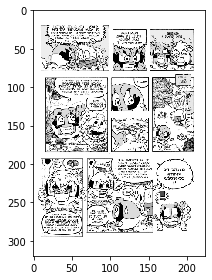

In [ ]:
io.imshow(test[0][0])

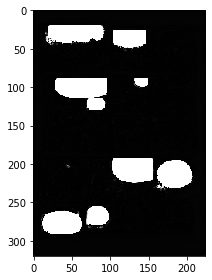

In [ ]:
io.imshow(test_res[0,:,:,0])

## evaluation

In [ ]:
def recall(pred, truth):
  pred = pred > 0.5
  TP = np.average(truth*pred)
  FP = np.average((1-truth)*pred)
  FN = np.average(truth*(1-pred))
  TN = np.average((1-truth)*(1-pred))
  if TP+FN==0: return 1
  return TP / (TP+FN)

def precision(pred, truth):
  pred = pred > 0.5
  TP = np.average(truth*pred)
  FP = np.average((1-truth)*pred)
  FN = np.average(truth*(1-pred))
  TN = np.average((1-truth)*(1-pred))
  if TP+FP==0: return 1
  return TP / (TP+FP)

def f1(pred, truth):
  r = recall(pred, truth)
  p = precision(pred, truth)
  if r+p==0: return 1
  return 2*r*p / (r+p)

In [ ]:
import pandas as pd

def predict_images(weights, imgs):
  ''' returns the unet's predictions for the given set of images '''

  model.load_weights(weights)
  return model.predict(imgs)


def mass_loss(loss_f, preds, truths):
  masses = [loss_f(p,t) for p,t in zip(preds, truths)]
  masses = np.asarray(masses, dtype=np.float32)
  return masses.flatten()


def test_predictions(preds, truths):
  ''' prints various metrics which measure the accuracy of the results '''

  info = np.array([
    [recall, "Recall"],
    [precision, "Precision"],
    [f1, "F1 Score"],
    [tversky_loss, "Tversky"],
    [dice_loss, "Dice"],
    [ks.losses.binary_crossentropy, "BCE"]
  ])
  losses = pd.DataFrame(info, columns=["obj", "desc"])
  accs = []
  for indx, row in losses.iterrows():
    res = mass_loss(row["obj"], preds, truths)
    # print(np.shape(res))
    accs.append(pd.DataFrame(res))
  losses["vals"] = accs
  print(' '*10, '\tavg\t\t', 'std-dev', sep='')
  for indx, row in losses.iterrows():
    print("%10s\t" % row["desc"], end='')
    print(np.average(row["vals"]), "\t", end='')
    print(np.std(row["vals"])[0], "\t", end='')
    print()

In [ ]:
# DICE LOSS

print("9991")
print("TRAIN")
print(test_predictions(train_res[:,:,:,0].astype(np.float32), train[1].astype(np.float32)))
print()
print("TEST")
print(test_predictions(test_res[:,:,:,0].astype(np.float32), test[1].astype(np.float32)))


9991
TRAIN
          	avg		std-dev
    Recall	0.99403405 	0.007725747 	
 Precision	0.9908613 	0.006250404 	
  F1 Score	0.9924192 	0.0049210656 	
   Tversky	0.048579056 	0.16735314 	
      Dice	0.022640001 	0.08450028 	
       BCE	0.0806313 	0.0871239 	
None

TEST
          	avg		std-dev
    Recall	0.96868193 	0.029567799 	
 Precision	0.9598013 	0.06417818 	
  F1 Score	0.96329916 	0.04325862 	
   Tversky	0.045932837 	0.035085604 	
      Dice	0.037232153 	0.043050904 	
       BCE	0.18459539 	0.42649448 	
None


In [ ]:
# TVERSKY LOSS

print("9992")
print("TRAIN")
print(test_predictions(train_res[:,:,:,0].astype(np.float32), train[1].astype(np.float32)))
print()
print("TEST")
print(test_predictions(test_res[:,:,:,0].astype(np.float32), test[1].astype(np.float32)))


9992
TRAIN
          	avg		std-dev
    Recall	0.95134515 	0.10104248 	
 Precision	0.95902926 	0.0788545 	
  F1 Score	0.94936496 	0.073408954 	
   Tversky	0.08152964 	0.1716841 	
      Dice	0.058324665 	0.07998395 	
       BCE	0.19622579 	0.6438022 	
None

TEST
          	avg		std-dev
    Recall	0.9440822 	0.0894622 	
 Precision	0.89159065 	0.14603005 	
  F1 Score	0.90574914 	0.097484775 	
   Tversky	0.08428001 	0.08407077 	
      Dice	0.09447692 	0.097472444 	
       BCE	0.3568312 	1.0467283 	
None


In [ ]:
# BINARY CROSS ENTROPY

print("9993")
print("TRAIN")
print(test_predictions(train_res[:,:,:,0].astype(np.float32), train[1].astype(np.float32)))
print()
print("TEST")
print(test_predictions(test_res[:,:,:,0].astype(np.float32), test[1].astype(np.float32)))


9993
TRAIN
          	avg		std-dev
    Recall	0.9884133 	0.009919202 	
 Precision	0.9930055 	0.0060097435 	
  F1 Score	0.99066585 	0.005509763 	
   Tversky	0.07034814 	0.16558875 	
      Dice	0.039596982 	0.14665735 	
       BCE	0.17407888 	0.1021069 	
None

TEST
          	avg		std-dev
    Recall	0.94339436 	0.11524859 	
 Precision	0.9545808 	0.08614106 	
  F1 Score	0.9473362 	0.09998493 	
   Tversky	0.0819247 	0.101137206 	
      Dice	0.056864433 	0.103053376 	
       BCE	0.2983617 	0.48786017 	
None


In [ ]:
# DICE + BCE

print("9994")
print("TRAIN")
print(test_predictions(train_res[:,:,:,0].astype(np.float32), train[1].astype(np.float32)))
print()
print("TEST")
print(test_predictions(test_res[:,:,:,0].astype(np.float32), test[1].astype(np.float32)))


9994
TRAIN
          	avg		std-dev
    Recall	0.976618 	0.054880172 	
 Precision	0.98476654 	0.01753585 	
  F1 Score	0.9796208 	0.031142289 	
   Tversky	0.08208416 	0.1677076 	
      Dice	0.049761362 	0.15147011 	
       BCE	0.21923988 	0.30185512 	
None

TEST
          	avg		std-dev
    Recall	0.94937795 	0.09977931 	
 Precision	0.92149967 	0.110474095 	
  F1 Score	0.9308512 	0.09522744 	
   Tversky	0.090561844 	0.09070046 	
      Dice	0.07037102 	0.09704136 	
       BCE	0.38399664 	0.66601634 	
None
